<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [0]:
train_data = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test_data  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

BATCH_SIZE = 64
CLASSES    = 10

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

Batch Size : 64
tensor(7)


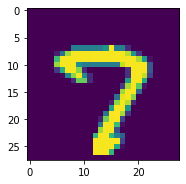

In [120]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for batch in trainSet:
    print("Batch Size :", len(batch[0]))
    # batch --> one batch containing BATCH_SIZE samples
    x, y = batch[0][i], batch[1][i]
    break

CHANNELS, DIM, DIM = x.shape
TOTAL_PIXELS = DIM*DIM

plt.subplot(1, 2, 1)
plt.imshow(x.view(DIM, DIM)) # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
print(y)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 512)
    self.fc2   = nn.Linear(512, CLASSES)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):

    x = self.convs(x)
    x = x.view(-1, self.flatten)
    sm = F.relu(self.fc1(x))
    # x = F.softmax(self.fc2(sm), dim=1)
    x = self.fc2(sm)

    return x, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc='Iteration : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
 
    loss_log.append(loss)
  
  return loss_log



def test(net, test_set):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        total += 1
        if real_class == pred_class:
          correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Accuracy : {round(accuracy, 2)} %')
  return accuracy, sm_log

Initiating Training..



Initiating Testing..




Accuracy : 97.63 %
Total Epochs : 1


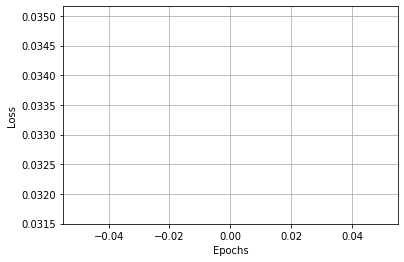

In [123]:
EPOCHS        = 1
LEARNING_RATE = 0.001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.xlabel('Epochs')
plt.ylabel('Loss')

accuracy, sm_log = test(net, testSet)

print(f'Total Epochs : {total_epochs}')

In [124]:
len(sm_log)

10000

In [125]:
classes = {}

for data in tqdm(sm_log):
  sm, label = data
  label = label.numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]

100%|██████████| 10000/10000 [00:00<00:00, 145985.82it/s]


In [126]:
torch.sum(classes['7'][0] - classes['7'][1])

tensor(4.3928, device='cuda:0')

In [127]:
torch.sum(classes['0'][0] - classes['0'][1])

tensor(-21.6258, device='cuda:0')

In [128]:
torch.sum(classes['9'][2] - classes['7'][1])


tensor(121.6293, device='cuda:0')

In [129]:
# FINDING THE MINIMUM SAMPLES to CLIP

clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))
print(clip)

892


In [0]:
# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

In [0]:
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

master = np.array(master)


In [161]:
diff = {}
for c in range(len(master)):
  for d in range(c, len(master)):
    diff[f'{c}-{d}'] = (torch.sum(np.sum(master[c] - master[d]))/892).cpu().numpy()

diff

{'0-0': array(0., dtype=float32),
 '0-1': array(85.048615, dtype=float32),
 '0-2': array(-4.211715, dtype=float32),
 '0-3': array(19.130077, dtype=float32),
 '0-4': array(-3.0495772, dtype=float32),
 '0-5': array(30.314837, dtype=float32),
 '0-6': array(10.920543, dtype=float32),
 '0-7': array(36.054638, dtype=float32),
 '0-8': array(6.813718, dtype=float32),
 '0-9': array(-10.665362, dtype=float32),
 '1-1': array(0., dtype=float32),
 '1-2': array(-89.260315, dtype=float32),
 '1-3': array(-65.91853, dtype=float32),
 '1-4': array(-88.09817, dtype=float32),
 '1-5': array(-54.73379, dtype=float32),
 '1-6': array(-74.128075, dtype=float32),
 '1-7': array(-48.993977, dtype=float32),
 '1-8': array(-78.2349, dtype=float32),
 '1-9': array(-95.713974, dtype=float32),
 '2-2': array(0., dtype=float32),
 '2-3': array(23.341778, dtype=float32),
 '2-4': array(1.1621499, dtype=float32),
 '2-5': array(34.526543, dtype=float32),
 '2-6': array(15.132229, dtype=float32),
 '2-7': array(40.266346, dtype=fl

TypeError: ignored

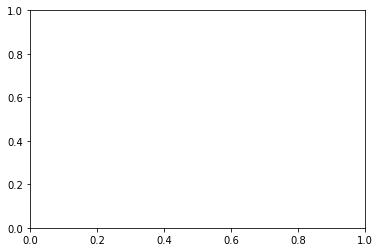